# Getting started with NLP: Traditional approaches
# Tokenization, Term-Document Matrix, TF-IDF and Text classification

In this notebook we continue to describe some traditional methods to address an NLP task, text classification.

This is an easy and fast to build text classifier, built based on a traditional approach to NLP problems. The steps to follow are:
- describe the process of tokenization
- how to build a Term-Document Matrix (using some methods like Counting words and TFIDF) as the numericalization method
- and then apply a machine learning classifier to predict or classify a tweet as real or fake.

## Problem Description
Twitter has become an important communication channel in times of emergency. The ubiquitousness of smartphones enables people to announce an emergency they’re observing in real-time. Because of this, more agencies are interested in programatically monitoring Twitter (i.e. disaster relief organizations and news agencies). But, it’s not always clear whether a person’s words are actually announcing a disaster.

In this problem, you’re challenged to build a machine learning model that predicts which Tweets are about real disasters and which one’s aren’t. You’ll have access to a dataset of 10,000 tweets that were hand classified.

This is a [Kaggle competition](https://www.kaggle.com/c/nlp-getting-started) to getting started in NLP.


### Importing the libraries

In [1]:
# Import utility libraries
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sn

%matplotlib inline
# Import libraries for text manipulation
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
# Import modules for evaluation purposes
# Import libraries for predcton
from sklearn import metrics
from sklearn.metrics import confusion_matrix,accuracy_score,roc_auc_score,roc_curve,auc,f1_score

from wordcloud import WordCloud

We set the variables for data location

In [2]:
# Global parameters
#root folder
root_folder='.'
#data_folder='.'
data_folder_name='data'
train_filename='cleaned_train.csv'
# Variable for data directory
DATA_PATH = os.path.abspath(os.path.join(root_folder, data_folder_name))

# Both train and test set are in the root data directory
train_path = DATA_PATH
test_path = DATA_PATH

#Relevant columns
TEXT_COLUMN = 'text'
TARGET_COLUMN = 'target'


### Loading the datasets

Each sample in the train and test set has the following information:

- The text of a tweet
- A keyword from that tweet (although this may be blank!)
- The location the tweet was sent from (may also be blank)

You are predicting whether a given tweet is about a real disaster or not. If so, predict a 1. If not, predict a 0.

**This notebook does not cover how to implement the best preprocessor to clean our tweets**. So we are going to feed our model with the tweet as is or only removing no alphanumeric characters. For a better results, we should inspect the tweets and apply some cleaning removing useless words, mispelling words, maybe the URIs,...  

In [3]:
#Read the tweets of our train dataset
data = pd.read_csv(train_path+'\\'+train_filename)
data.head()

,id,keyword,location,text,target
0,1,NaN,NaN,our deeds are the reason of this earthquake ma...,1
1,4,NaN,NaN,forest fire near la ronge sask . canada,1
2,5,NaN,NaN,all residents asked to 'shelter in place ' are...,1
3,6,NaN,NaN,"13,000 people receive wildfires evacuation ord...",1
4,7,NaN,NaN,just got sent this photo from ruby alaska as s...,1


In [4]:
#Extract only the text and target columns from our dataframe
data = data[[TEXT_COLUMN, TARGET_COLUMN]]
data.head()

,text,target
0,our deeds are the reason of this earthquake ma...,1
1,forest fire near la ronge sask . canada,1
2,all residents asked to 'shelter in place ' are...,1
3,"13,000 people receive wildfires evacuation ord...",1
4,just got sent this photo from ruby alaska as s...,1


## Splitting the dataset into train and test set

We split the train dataset into a train and validation dataset so we can evaluate the result and apply tricks like cross-validation. This job is done as in many others notebooks, using sklearn. 

In [5]:
X_train, X_test, y_train, y_test = train_test_split(data[TEXT_COLUMN], data[TARGET_COLUMN].values , test_size=0.20, random_state=0)
# Show the size of our datasets
print('X Train Size:',X_train.shape)
print('X Test Size:',X_test.shape)

X Train Size: (6090,)
X Test Size: (1523,)


## Tokenization: the building blocks in NLP

Tokenization is a common task in Natural Language Processing. It’s a fundamental step in both traditional methods like Count Vectorizer and in deep Learning-based architectures like RNN or Transformers.

*Given a character sequence and a defined document unit, tokenization is the task of chopping it up into pieces, called tokens , perhaps at the same time throwing away certain characters, such as punctuation. Here is an example of tokenization:*[1]

> Input: Friends, Romans, Countrymen, lend me your ears;
>
>  Output: "Friends", "Romans", "Countrymen", "lend", "me", "your"

These tokens are often loosely referred to as terms or words, but it is sometimes important to make a type/token distinction. A token is an instance of a sequence of characters in some particular document that are grouped together as a useful semantic unit for processing. A type is the class of all tokens containing the same character sequence. A term is a (perhaps normalized) type that is included in the IR system's dictionary. The set of index terms could be entirely distinct from the tokens.

Tokens can be either words, characters, or subwords. Hence, tokenization can be broadly classified into 3 types – word, character, and subword (n-gram characters) tokenization. The most common way of forming tokens is based on space. Assuming space as a delimiter, the tokenization of the sentence "Here it comes" results in 3 tokens "Here", "it" and "comes". As each token is a word, it becomes an example of Word tokenization.

Tokenization is the foremost step while modeling text data. Tokenization is performed on the corpus to obtain tokens. The following tokens are then used to prepare a vocabulary. Vocabulary refers to the set of unique tokens in the corpus. Remember that vocabulary can be constructed by considering each unique token in the corpus or by considering the top K Frequently Occurring Words.

One of the major issues with word tokenization is dealing with **Out Of Vocabulary (OOV) words**. OOV words refer to the new words which are encountered at testing. These new words do not exist in the vocabulary.During test time, any word that is not present in the vocabulary will be mapped to a UNK token. This is how we can tackle the problem of OOV in word tokenizers. One problem with this approach is that the entire information of the word is lost as we are mapping OOV to UNK tokens. The structure of the word might be helpful in representing the word accurately. And another issue is that every OOV word gets the same representation.

Another issue with word tokens is connected to the size of the vocabulary, pre-trained models are trained on a large volume of the text corpus so the vocabulary size explodes to thousands or hundred of thousands words.

**Character Tokenization** splits a piece of text into a set of characters. Character Tokenizers handles OOV words coherently by preserving the information of the word. It breaks down the OOV word into characters and represents the word in terms of these characters. It also limits the size of the vocabulary. Want to talk a guess on the size of the vocabulary? 26 since the vocabulary contains a unique set of characters. Some especial character are usually include but the vocabulary size do not exceed one or two hundred words.

*In our example, the tokenization process is done inside the function used to process the text. The library sklearn and their modules will tokenize the text and then apply a technique to transform those tokens into a numerical representation.*


## Creating features or numericalizing the text: Term-Document Matrix

*A document-term matrix or term-document matrix is a mathematical matrix that describes the frequency of terms that occur in a collection of documents. In a document-term matrix, rows correspond to documents in the collection and columns correspond to terms. There are various schemes for determining the value that each entry in the matrix should take. One such scheme is tf-idf. They are useful in the field of natural language processing.*

We can consider a **Document Term Matrix (DTM)** as an implementation of the Bag of Words concept. Term Document Matrix is tracking the term frequency for each term by each document. You start with the Bag of Words representation of the documents and then for each document, you track the number of time a term exists. Term count is a common metric to  use in a Document Term Matrix  but it is not the only metric. It should be very easy to see that the DTM representation contains each distinct term from the corpus ( a collection of documents)  and the count of each distinct term in each document. A Document Term matrix can become a very large, sparse matrix (so much 0s than values) depending on the number of documents in the corpus and the number of terms in each document. We can now calculate basic statistics such as average term count, mean, median, mode, variance and standard deviation of the length of the documents. We can also tell which terms are more frequent in the collection of documents and can use that information to determine which terms more likely “represent” the document.

Considering that our data is a collections of tweets (documents) in text format the process will need to tokenize the text to get a set of tokens (items in our vocabulary), in this stage we usually reduce the number of terms o tokens, removing those that seems to be not relevant. If our vocab contains too many words, many of them not relevant, we will spend many resources and our DTM could be useless to the process.


### Count Vectorizer

Now it is time to convert a collection of text documents (our tweets) to a matrix of token/word counts. if you do not provide an a-priori dictionary and you do not use an analyzer that does some kind of feature selection then the number of features will be equal to the vocabulary size found by analyzing the data.

We simply count the times that the term appears in the document and it will be the value of their corresponding cell. 

In [13]:
# Create a Counter of tokens
count_vectorizer = CountVectorizer(decode_error='ignore', lowercase=True, min_df=2)
# Apply it on the train data to get the vocabulary and the mapping. This vocab and mapping is then applied to the test set.
# Before, we convert to Unicode to avoid issues with CountVectorizer
train = count_vectorizer.fit_transform(X_train.values.astype('U'))
test = count_vectorizer.transform(X_test.values.astype('U'))

In [14]:
print('Train size: ',train.shape)
print('Test size: ',test.shape)

Train size:  (6090, 5619)
Test size:  (1523, 5619)


Our term-document matrix is a 6090 x 12063 matrix (this value can vary depending on text reprocessing applied), 6090 documents or tweets and a dictionary of size 12063.

Lets plot some item in the vocabulary. We need the vocaulary to translate from the integer value of a word to the corresponding word, it is created in the function or process to write the term document matrix and we can use it to "reverse" the data from numbers to text.  

In [15]:
# Extract the vocabulary as a list of (word, frequency)
vocab = list(count_vectorizer.vocabulary_.items())
print(vocab[:10])

[('ted', 4903), ('cruz', 1324), ('fires', 2003), ('back', 538), ('at', 479), ('jeb', 2710), ('bush', 863), ('lose', 3012), ('because', 611), ('of', 3511)]


## TF-IDF
Another technique to create the DTM is the **TF-IDF**. In information retrieval, tf–idf or TFIDF, short for *term frequency–inverse document frequency*, is a numerical statistic that is intended to reflect how important a word is to a document in a collection or corpus. It is often used as a weighting factor in searches of information retrieval, text mining, and user modeling. The tf–idf value increases proportionally to the number of times a word appears in the document and is offset by the number of documents in the corpus that contain the word, which helps to adjust for the fact that some words appear more frequently in general. tf–idf is one of the most popular term-weighting schemes today.

TF-IDF is the product of two statistics, **term frequency** and **inverse document frequency**. There are various ways for determining the exact values of both statistics, for example:

- The term frequency of a word in a document. There are several ways of calculating this frequency, with the simplest being a raw count of instances a word appears in a document. Then, there are ways to adjust the frequency, by length of a document, or by the raw frequency of the most frequent word in a document.

- The inverse document frequency of the word across a set of documents. This means, how common or rare a word is in the entire document set. The closer it is to 0, the more common a word is. This metric can be calculated by taking the total number of documents, dividing it by the number of documents that contain a word, and calculating the logarithm.

$$TF-IDF = tf_{i,j} x log(\frac{N}{df_i})$$

where $N$ = total number of documents, $tf_{i,j}$ = number of ocurrences of i in j, $df_i$ = number of documents containing i
    

In [23]:
# try multiple ways of calculating features
# Create the numericalizer TFIDF for lowercase
tfidf = TfidfVectorizer(decode_error='ignore', lowercase = True, min_df=2)
# Numericalize the train dataset
train = tfidf.fit_transform(X_train.values.astype('U'))
# Numericalize the test dataset
test = tfidf.transform(X_test.values.astype('U'))

In [24]:
print('Train size: ',train.shape)
print('Test size: ',test.shape)

Train size:  (6090, 5619)
Test size:  (1523, 5619)


## Create and train the models

Once you’ve transformed words into numbers, in a way that’s machine learning algorithms can understand, the TF-IDF score (or other vectorizer method) can be fed to classification algorithms such as Naive Bayes and Support Vector Machines, greatly improving the results of more basic methods like word counts.

### Naive Bayes

We are going to use a traditional classifier used frequently in text classification: Naive Bayes using multinomial models. 
The multinomial Naive Bayes classifier is suitable for classification with discrete features (e.g., word counts for text classification). The multinomial distribution normally requires integer feature counts. However, in practice, fractional counts such as tf-idf may also work.

In other notebook we will talk about Naive Bayes and Bayes rule, describing why they produce great resuls in NLP task. 

Just for comparison purposes, we will build others classifier for binary classfication to check if our model performance is good enough for this task, as an initial soluction to improve.  


In [25]:
# create the model, train it on the train dataset and print the scores
model = MultinomialNB()
model.fit(train, y_train)
print("train score:", model.score(train, y_train))
print("test score:", model.score(test, y_test))

train score: 0.8596059113300493
test score: 0.7944845699277742


Evaluate the Naive Bayes classifier, but first we create some helper functions to plot the results

In [26]:
# Create the confussion matrix
def plot_confussion_matrix(y_test, y_pred):
    ''' Plot the confussion matrix for the target labels and predictions '''
    cm = confusion_matrix(y_test, y_pred)

    # Create a dataframe with the confussion matrix values
    df_cm = pd.DataFrame(cm, range(cm.shape[0]),
                  range(cm.shape[1]))
    #plt.figure(figsize = (10,7))
    # Plot the confussion matrix
    sn.set(font_scale=1.4) #for label size
    sn.heatmap(df_cm, annot=True,fmt='.0f',annot_kws={"size": 10})# font size
    plt.show()

In [27]:
# ROC Curve
# plot no skill
# Calculate the points in the ROC curve
def plot_roc_curve(y_test, y_pred):
    ''' Plot the ROC curve for the target labels and predictions'''
    fpr, tpr, thresholds = roc_curve(y_test, y_pred, pos_label=1)
    roc_auc= auc(fpr,tpr)

    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

              precision    recall  f1-score   support

           0    0.77897   0.90293   0.83638       886
           1    0.82661   0.64364   0.72374       637

    accuracy                        0.79448      1523
   macro avg    0.80279   0.77329   0.78006      1523
weighted avg    0.79890   0.79448   0.78927      1523



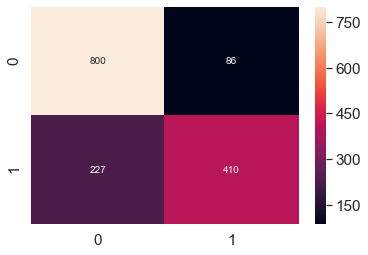

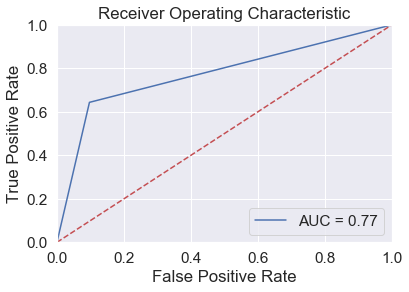

In [28]:
# Predicting the Test set results
y_pred = model.predict(test)

print(metrics.classification_report(y_test, y_pred,  digits=5))
plot_confussion_matrix(y_test, y_pred)
plot_roc_curve(y_test, y_pred)

## Suport Vector Machine Classifier
### What is Support Vector Machines?

*The objective of the support vector machine algorithm is to find a hyperplane in an N-dimensional space(N — the number of features) that distinctly classifies the data points.*

In a binary classification problem, to separate the two classes of data points, there are many possible hyperplanes that could be chosen. Our objective is to find a plane that has the maximum margin, i.e the maximum distance between data points of both classes. Maximizing the margin distance provides some reinforcement so that future data points can be classified with more confidence. Support vectors are data points that are closer to the hyperplane and influence the position and orientation of the hyperplane. Using these support vectors, we maximize the margin of the classifier.

We can use SVM algorithm to predict if a tweet is fake or real, it is just a binary classifcation problem. 

In [30]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

# Define the parameters to tune
parameters = { 
    'C': [1.0, 10],
    'gamma': [1, 'auto', 'scale']
}
# Tune yyperparameters  using Grid Search and a SVM model
model = GridSearchCV(SVC(kernel='rbf'), parameters, cv=5, n_jobs=-1).fit(train, y_train)

Once our model is trained we can evaluate the performance as we did previously:

              precision    recall  f1-score   support

           0    0.79492   0.91874   0.85236       886
           1    0.85571   0.67033   0.75176       637

    accuracy                        0.81484      1523
   macro avg    0.82532   0.79453   0.80206      1523
weighted avg    0.82035   0.81484   0.81028      1523



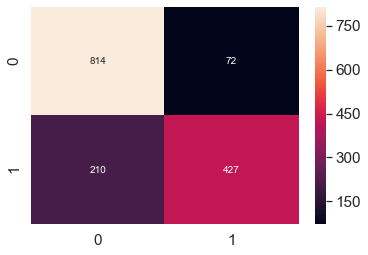

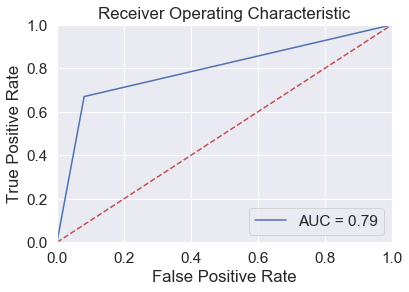

In [31]:
# Predicting the Test set results
y_pred = model.predict(test)

print(metrics.classification_report(y_test, y_pred,  digits=5))
plot_confussion_matrix(y_test, y_pred)
plot_roc_curve(y_test, y_pred)

This simple SVM increase the performance of our model.

## XGBoost classifier

XGBoost is an implementation of gradient boosted decision trees designed for speed and performance that is dominative competitive machine learning. This is a good dataset for a first XGBoost model because all of the input variables are numeric and the problem is a simple binary classification problem.

XGBoost is an advanced version of gradient boosting, rather than training all of the models in isolation of one another, boosting trains models in succession, with each new model being trained to correct the errors made by the previous ones. Models are added sequentially until no further improvements can be made.

XGBoost provides a wrapper class to allow models to be treated like classifiers or regressors in the scikit-learn framework. This means we can use the full scikit-learn library with XGBoost models.

In [32]:
from lightgbm import LGBMClassifier
from sklearn.metrics import f1_score


def f1_metric(ytrue,preds):
    ''' Return the F1 Score value for the preds and true values, ytrue '''
    return 'f1_score', f1_score((preds>=0.5).astype('int'), ytrue, average='macro'), True

params = {
    'learning_rate': 0.06,
    'n_estimators': 1500,
    'colsample_bytree': 0.5,
    'metric': 'f1_score'
}

full_clf = LGBMClassifier(**params)

# Fit or train the xgboost model
full_clf.fit(train.astype(np.float32), y_train, eval_set=[(train.astype(np.float32), y_train), (test.astype(np.float32), y_test)],
             verbose=400, eval_metric=f1_metric)
#Show the results
print("train score:", full_clf.score(train.astype(np.float32), y_train))
print("test score:", full_clf.score(test.astype(np.float32), y_test))

C:\Users\edumu\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


[400]	valid_0's f1_score: 0.919876	valid_1's f1_score: 0.770098
[800]	valid_0's f1_score: 0.956615	valid_1's f1_score: 0.764821
[1200]	valid_0's f1_score: 0.970297	valid_1's f1_score: 0.75265
train score: 0.9765188834154351
test score: 0.7616546290216678


Now, we can predict on the test dataset to get the results and compare with others methods.

              precision    recall  f1-score   support

           0    0.79492   0.91874   0.85236       886
           1    0.85571   0.67033   0.75176       637

    accuracy                        0.81484      1523
   macro avg    0.82532   0.79453   0.80206      1523
weighted avg    0.82035   0.81484   0.81028      1523



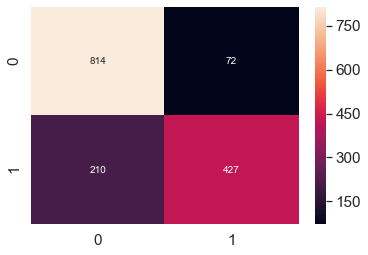

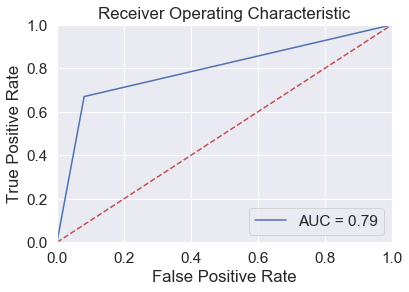

In [33]:
# Predicting the Test set results
Y_pred = full_clf.predict(test.astype(np.float32))

print(metrics.classification_report(y_test, y_pred,  digits=5))
plot_confussion_matrix(y_test, y_pred)
plot_roc_curve(y_test, y_pred)

**So, we can observe that applying some "old" and simple techniques without "fine-tune" we obtain a classifier in a few lines of code and no more than one hour of processing time. And this classifier can predict with a relatively high confidence when a tweet is announcing a fake or real disaster.**

## Visualize some results from our text

Another tool we can use to analyze the results is a WordCloud where we can draw the most relevant words in the fake tweets and real tweets. 

In [34]:
# visualize the data on a WordCloud
def visualize(label):
  words = ''
  for msg in data[data[TARGET_COLUMN] == label][TEXT_COLUMN]:
    msg = msg.lower()
    words += msg + ' '
  wordcloud = WordCloud(width=600, height=600).generate(words)
  plt.imshow(wordcloud)
  plt.axis('off')
  plt.show()

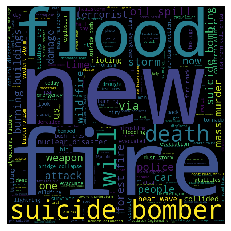

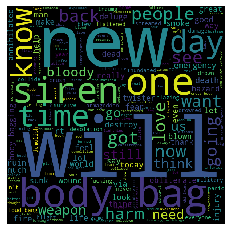

In [35]:
visualize(1)
visualize(0)

### Some links to review:

- [1]: https://nlp.stanford.edu/IR-book/html/htmledition/tokenization-1.html

- [2]: https://www.analyticsvidhya.com/blog/2020/05/what-is-tokenization-nlp/

- http://www.darrinbishop.com/blog/2017/10/text-analytics-document-term-matrix/